## Import packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
from scipy.stats import linregress
from scipy.signal import butter, filtfilt, resample
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display
from io import StringIO
import os

## Load raw 'Fluorescence' csv file:
Access the widget with the upload prompt.

In the same step we 1) convert timestamps to seconds, 2) rename the 410 and 470 channels to 'UV' and 'Fluorescence', respectively. Note that we drop the header found in the raw 'Fluorescence' file that contains metadata related to signal acquisition. This metadata can be useful to reference, for example identifying your sampling rate and illumination intensity.

In [2]:
# Initialize global variables
dfraw = None
filename = None
df_events_resampled = None

# Create a file upload widget
upload_widget = widgets.FileUpload(accept='.csv', multiple=False)
display(upload_widget)

def on_file_upload_change(change):
    global dfraw, filename, df_events_resampled  # Declare variables as global to modify them within the function
    
    # Check if any file has been uploaded
    if upload_widget.value:
        # Get the uploaded file metadata and content
        uploaded_file = list(upload_widget.value.values())[0]
        content = uploaded_file['content']
        filename = uploaded_file['metadata']['name']
        
        # Decode the content and create a DataFrame, skipping the first row
        dfraw = pd.read_csv(StringIO(content.decode('utf-8')), skiprows=1)
        
        # Check if 'TimeStamp' column exists
        if 'TimeStamp' in dfraw.columns:
            print("Uploaded file successfully loaded into DataFrame 'dfraw'.")
            
            # Multiply the "TimeStamp" column by 1000
            dfraw['TimeStampAdjusted'] = dfraw['TimeStamp'] / 1000
            
            # Rename columns: "CH1-410" to "UV" and "CH1-470" to "Fluorescence"
            dfraw.rename(columns={'CH1-410': 'UV', 'CH1-470': 'Fluorescence'}, inplace=True)
            
            # Drop any column that contains 'Unnamed' in its column name
            dfraw = dfraw.loc[:, ~dfraw.columns.str.contains('^Unnamed')]
            
            print(dfraw.head())  # Display the first few rows of the DataFrame
            
            # Simulate additional processing steps
            # For example, let's assume df_events_resampled is the result of your processing
            df_events_resampled = dfraw  # Replace this with your actual processing logic
            
            print("Processing complete. Ready to save the processed file.")
        else:
            print("Error: 'TimeStamp' column not found in the uploaded file.")
            print("Available columns:", dfraw.columns)
    else:
        print("No file was selected.")

# Attach the file upload change event to the handler function
upload_widget.observe(on_file_upload_change, names='value')

FileUpload(value={}, accept='.csv', description='Upload')

Uploaded file successfully loaded into DataFrame 'dfraw'.
   TimeStamp Events        UV  Fluorescence  TimeStampAdjusted
0      0.000    NaN  1214.693       779.522           0.000000
1     20.000    NaN  1214.550       779.127           0.020000
2     39.994    NaN  1214.240       778.667           0.039994
3     59.998    NaN  1214.687       778.503           0.059998
4     79.996    NaN  1213.187       777.752           0.079996
Processing complete. Ready to save the processed file.


## Visualize your raw fluorescence and control signals:

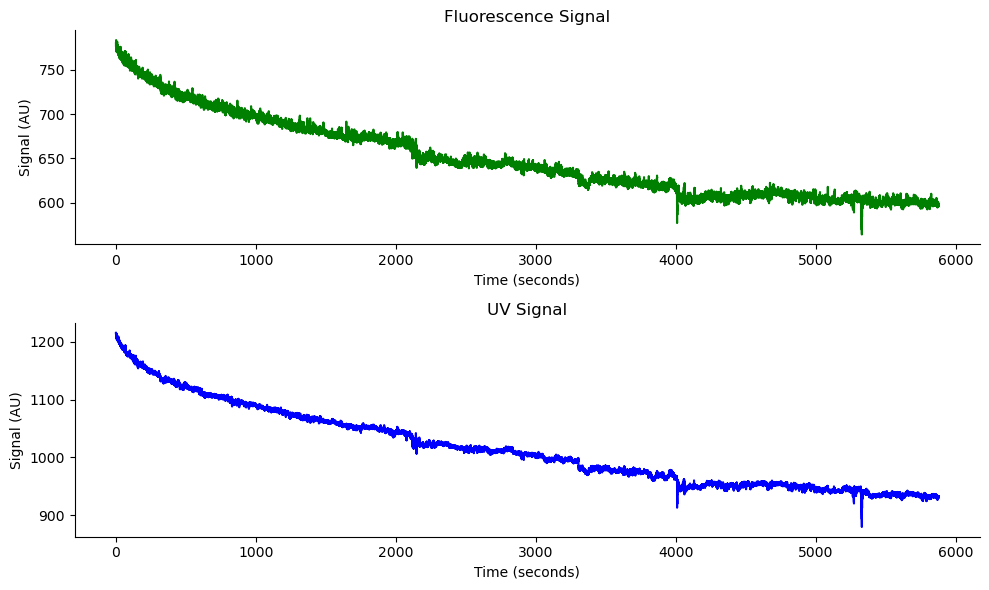

In [3]:
#create a new copy to work with (we can go back to this step if we need to without re-importing the .csv file)
df = dfraw.copy()

# Initialize a figure with 2 subplots, arranged vertically
fig, axs = plt.subplots(2, 1, figsize=(10, 6))  # 'figsize' is optional, adjust it as needed

# First subplot for 'Fluorescence'
axs[0].plot(df['TimeStampAdjusted'], df['Fluorescence'], 'g', label='Fluorescence')
axs[0].set_title('Fluorescence Signal')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal (AU)')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Second subplot for 'UV'
axs[1].plot(df['TimeStampAdjusted'], df['UV'], 'b', label='UV')
axs[1].set_title('UV Signal')  # Set title for the second subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the second subplot
axs[1].set_ylabel('Signal (AU)')  # Set y-axis label for the second subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

## Fit a double exponential (fast and slow decay) to Fluorescence and UV signal:

For our debleaching approach, we fit a double exponential to both the fluorescence and UV signals. The fitted curves are plotted in red, and will be subtracted from the raw signals. We use a double exponential because it best approximates the bleaching rate. Bleaching tends to be faster earlier on during the recording and overtime more slowly decays.

You can adjust the parameters and bounds and visually inspect the fitted exponential.

Curve Fitting: 100%|██████████████████████████████████████████████| 100/100 [00:01<00:00, 51.60it/s]


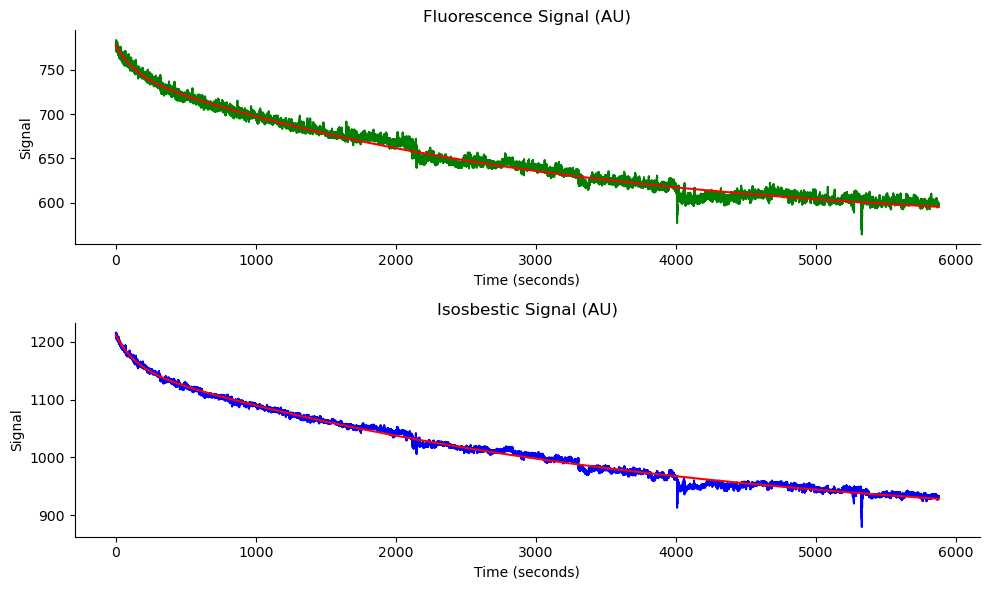

In [4]:
def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    '''Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset.
    amp_fast: Amplitude of the fast component.
    amp_slow: Amplitude of the slow component.
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow.
    '''
    tau_fast = tau_slow * tau_multiplier
    return const + amp_slow * np.exp(-t / tau_slow) + amp_fast * np.exp(-t / tau_fast)

# Set parameters and bounds
time_seconds = df['TimeStampAdjusted']
raw_Fluorescence = df['Fluorescence']
raw_iso = df['UV']

max_sig_fluor = np.max(raw_Fluorescence)
bounds_fluor = ([0, 0, 0, 0, 0],
                [max_sig_fluor, max_sig_fluor, max_sig_fluor, 36000, 1])
initial_params_fluor = [max_sig_fluor / 2, max_sig_fluor / 4, max_sig_fluor / 4, 7500, 0.1]

max_sig_iso = np.max(raw_iso)
bounds_iso = ([0, 0, 0, 0, 0],
              [max_sig_iso, max_sig_iso, max_sig_iso, 36000, 1])
initial_params_iso = [max_sig_iso / 2, max_sig_iso / 4, max_sig_iso / 4, 7500, 0.1]

# Fit curves with tqdm progress bar
def fit_curve(time_data, raw_data, initial_params, bounds):
    pbar = tqdm(total=100, desc='Curve Fitting', ncols=100)
    params, param_cov = curve_fit(double_exponential, time_data, raw_data,
                                  p0=initial_params, bounds=bounds, maxfev=1000)
    pbar.update(100)  # Update to 100% as it is a single step
    pbar.close()
    return params

Fluorescence_params = fit_curve(time_seconds, raw_Fluorescence, initial_params_fluor, bounds_fluor)
iso_params = fit_curve(time_seconds, raw_iso, initial_params_iso, bounds_iso)

Fluorescence_expfit = double_exponential(time_seconds, *Fluorescence_params)
iso_expfit = double_exponential(time_seconds, *iso_params)

# Initialize a figure with 2 subplots, arranged vertically
fig, axs = plt.subplots(2, 1, figsize=(10, 6))  # 'figsize' is optional, adjust it as needed

# First subplot for 'Fluorescence'
axs[0].plot(time_seconds, raw_Fluorescence, 'g', label='Fluorescence')
axs[0].plot(time_seconds, Fluorescence_expfit, 'r', label='Fit')
axs[0].set_title('Fluorescence Signal (AU)')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Second subplot for 'Iso'
axs[1].plot(time_seconds, raw_iso, 'b', label='Iso')
axs[1].plot(time_seconds, iso_expfit, 'r', label='Fit')
axs[1].set_title('Isosbestic Signal (AU)')  # Set title for the second subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the second subplot
axs[1].set_ylabel('Signal')  # Set y-axis label for the second subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Subtract fitted exponentials from both the 'Fluorescence' and 'UV' signals to debleach:

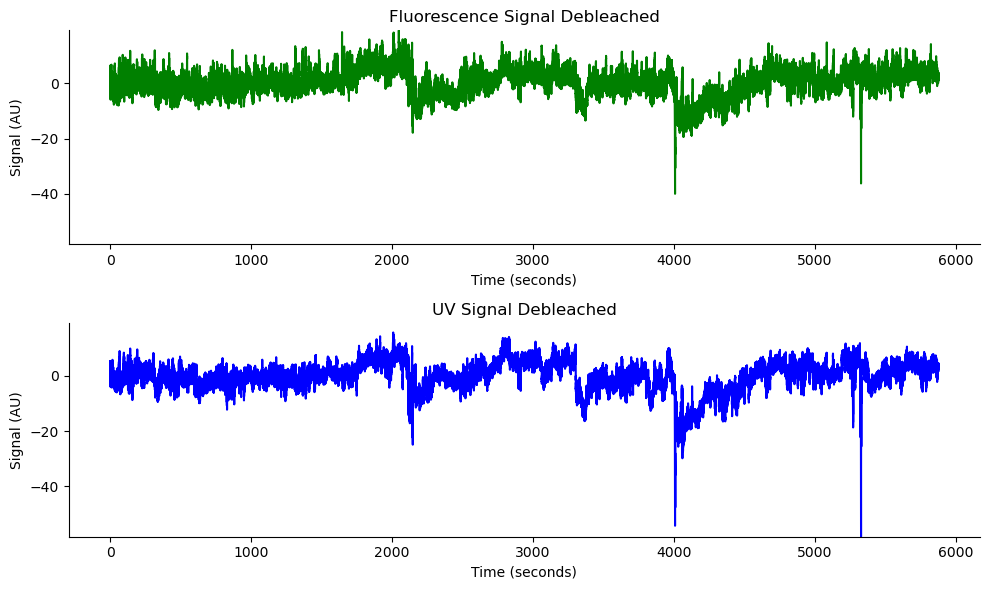

In [5]:
Fluorescence_debleached = raw_Fluorescence - Fluorescence_expfit
iso_debleached = raw_iso - iso_expfit

# Determine common y-axis limits
y_min = min(Fluorescence_debleached.min(), iso_debleached.min())
y_max = max(Fluorescence_debleached.max(), iso_debleached.max())

# Initialize a figure with 2 subplots, arranged vertically
fig, axs = plt.subplots(2, 1, figsize=(10, 6))  # 'figsize' is optional, adjust it as needed

# First subplot for 'Fluorescence'
axs[0].plot(time_seconds, Fluorescence_debleached, 'g')
axs[0].set_title('Fluorescence Signal Debleached')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal (AU)')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_ylim(y_min, y_max)  # Set the same y-axis limits

# Second subplot for 'UV'
axs[1].plot(time_seconds, iso_debleached, 'b')
axs[1].set_title('UV Signal Debleached')  # Set title for the second subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the second subplot
axs[1].set_ylabel('Signal (AU)')  # Set y-axis label for the second subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].set_ylim(y_min, y_max)  # Set the same y-axis limits

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

## Linear fit of debleached 'Fluorescence' and 'UV' signal to perform motion correction:

We first plot a scatter plot of the debleached 'Fluorescence' and 'UV' values and compute a linear regression. Next, we fit the 'UV' signal to the 'Fluorescence' signal by passing the values through the slope and intercept computed from our linear regression. This scaled data is plotted in the red scatter plot. Assuming that the fitted line approximates the data well, we shouldn't expect a big difference between the raw and scaled data. 

We do this because we want to scale the two signals in the same way in order to completely subtract the debleached 'UV' signal from the debleached 'Fluorescence' signal, and only calcium-dependent (if you're using GCaMP) signal should remain.

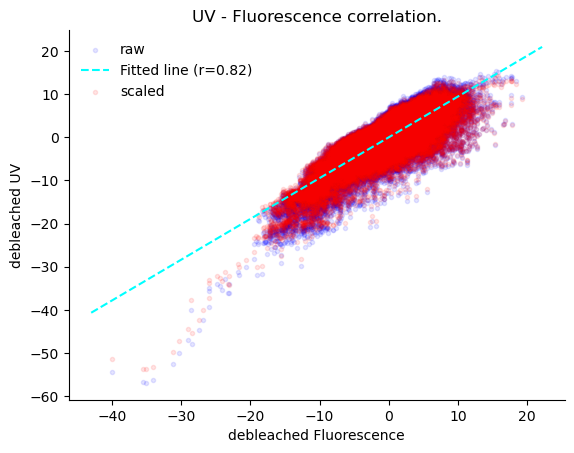

In [6]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x=Fluorescence_debleached, y=iso_debleached)

# Scatter plot of the data
plt.scatter(Fluorescence_debleached[::5], iso_debleached[::5], alpha=0.1, marker='.', color='b', label="raw")

# Plot the fitted line
x = np.array(plt.xlim())
plt.plot(x, intercept + slope * x, color='cyan', linestyle="--", label=f'Fitted line (r={r_value:.2f})')

# Labels and title
plt.ylabel('debleached UV')
plt.xlabel('debleached Fluorescence')
plt.title('UV - Fluorescence correlation.')

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Compute the estimated motion of the fluorescence signal and subtract to get motion-corrected signal
Fitted_UV = intercept + slope * iso_debleached
Fluorescence_corrected = Fluorescence_debleached - Fitted_UV

# Scatter plot of the scaled data
plt.scatter(Fluorescence_debleached[::5], Fitted_UV[::5], alpha=0.1, marker='.', color='r', label="scaled")

# Labels and title
plt.ylabel('debleached UV')
plt.xlabel('debleached Fluorescence')
plt.title('UV - Fluorescence correlation.')

# Legend
plt.legend(frameon=False)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.show()

## Visualization of motion corrected 'Fluorescence' signal:

We plot our previously calculated debleached 'fluorescence' signal (before motion correction) and our estimated motion, which is the 'UV' signal that was passed through our linear regression. Finally, we visualize the 'Fluorescence' signal that has been debleached and motion corrected, which was achieved through our double exponential fit and 'UV' signal subtraction, respectively.

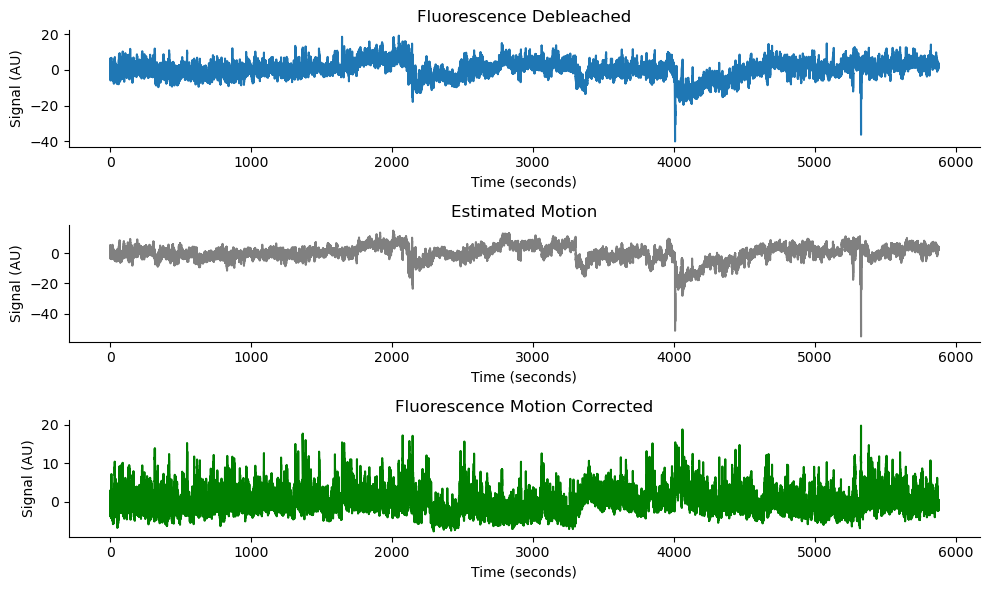

In [7]:
# Create a figure with 3 subplots, arranged vertically
fig, axs = plt.subplots(3, 1, figsize=(10, 6))  # 'figsize' is optional, adjust as needed

# First subplot for 'Fluorescence debleached'
axs[0].plot(time_seconds, Fluorescence_debleached, label='Fluorescence debleached')
axs[0].set_title('Fluorescence Debleached')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal (AU)')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Third subplot for 'estimated motion'
axs[1].plot(time_seconds, Fitted_UV, 'gray', label='Estimated Motion')
axs[1].set_title('Estimated Motion')  # Set title for the third subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the third subplot
axs[1].set_ylabel('Signal (AU)')  # Set y-axis label for the third subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Second subplot for 'fluorsence motion corrected'
axs[2].plot(time_seconds, Fluorescence_corrected, 'g', label='Fluorescence motion corrected')
axs[2].set_title('Fluorescence Motion Corrected')  # Set title for the second subplot
axs[2].set_xlabel('Time (seconds)')  # Set x-axis label for the second subplot
axs[2].set_ylabel('Signal (AU)')  # Set y-axis label for the second subplot
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Downsampling and bandpass filtering:

On our motion corrected and debleached 'Fluorescence' signal, we want to do some simple signal processing to clean-up. Depending on your acquisition settings, you might want to downsample your data -- which is especially useful for batch processing multiple files (downsample your data to make sure your files are all the same). The fs_orig (original sampling rate) is computed from your raw file timestamps, and you can specify your desired sampling rate.

On RWD systems, the raw 'Fluorescence' file stores your behavioral events (TTL, depends on your wiring into the system) simultaneously aligned to the photometry data. During our downsampling, we also downsample the events (without dropping them) and re-align them to our downsampled 'Fluorescence' signal. The dataframe is stored in *df_events_resampled*, make sure you inspect this to make sure that your events aren't being lost. 

For bandpass filtering, we apply a butterworth filter. Since calcium transients are neither high frequency or low frequency, we specify a lowcut and highcut threshold to clean up our signal from potential acquisition noise. You can change the cutoff thresholds you suit your needs. 

## Parameters to adjust (specify in hz):
- **fs** 
- **lowcut** 
- **highcut** 

In [8]:
# Compute fs_orig from the time differences in 'TimeStampAdjusted'
time_stamps = df['TimeStampAdjusted']
time_diffs = np.diff(time_stamps)  # Calculate time differences between consecutive samples
mean_time_diff = np.mean(time_diffs)  # Average time difference
fs_orig = 1 / mean_time_diff  # Compute original sampling rate

# Desired sampling rate
fs = 15

# Generate new timestamps based on the desired sampling rate
num_samples = int(len(Fluorescence_corrected) * fs / fs_orig)
time_seconds_resampled = np.linspace(time_stamps.iloc[0], time_stamps.iloc[-1], num_samples)

# Interpolate the original data to match the new timestamps
Fluorescence_corrected_interpolated = np.interp(time_seconds_resampled, time_stamps, Fluorescence_corrected)

# Create a DataFrame for the resampled data
df_resampled = pd.DataFrame({'TimeStamp': time_seconds_resampled, 'Fluorescence_Corrected': Fluorescence_corrected_interpolated})

# Preserve the event strings
events = df[['Events']].copy()
events['Time'] = time_stamps

# Merge the resampled data with the events
df_events_resampled = pd.merge_asof(df_resampled, events, left_on='TimeStamp', right_on='Time', direction='nearest')
df_events_resampled.drop(columns=['Time'], inplace=True)

# Desired cutoff frequencies (in Hz)
lowcut = 0.005
highcut = 5

# Design the Butterworth band-pass filter
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Apply the filter to your data.
Fluorescence_corrected_filtered = butter_bandpass_filter(df_events_resampled['Fluorescence_Corrected'], lowcut, highcut, fs, order=3)
df_events_resampled['Fluorescence_Corrected_Filtered'] = Fluorescence_corrected_filtered

## Visualize your original data, downsampled data, and filtered data:

The bandpass filter is being applied on top of the downsampled data. The range of your zoomed in data can be adjusted by changing the **start_time** and **end_time** variables, in seconds. 

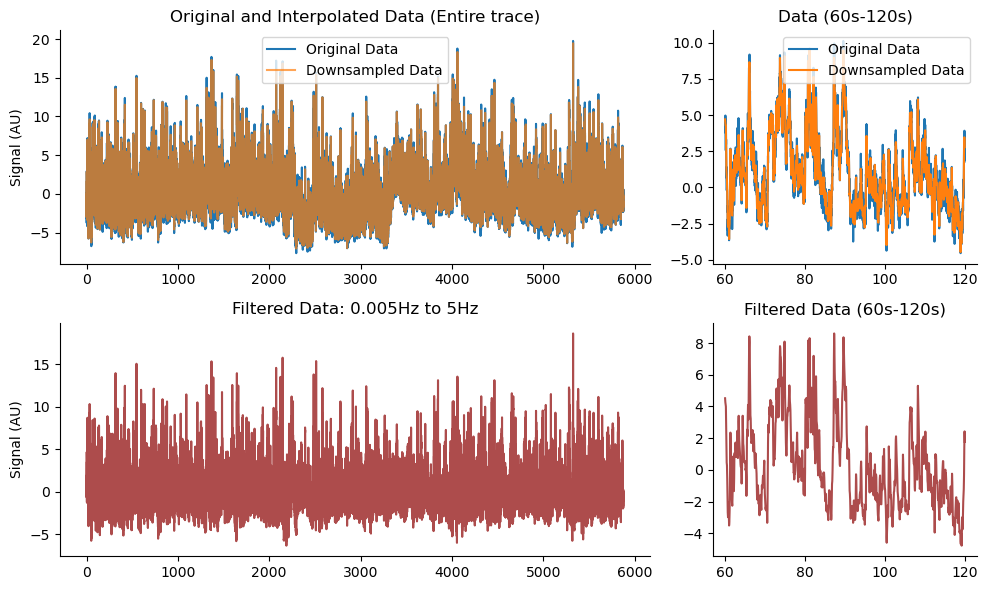

In [9]:
# Plotting the downsampled and filtered data
fig = plt.figure(figsize=(10, 6))  # You can adjust the overall figure size as needed

# First row, first subplot: Original Data (full series)
# Spanning two columns for double width
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax1.plot(time_stamps, Fluorescence_corrected, label='Original Data', alpha=1)
ax1.plot(time_seconds_resampled, Fluorescence_corrected_interpolated, label='Downsampled Data', alpha=0.7)
ax1.set_title('Original and Interpolated Data (Entire trace)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel('Signal (AU)')
ax1.legend()

# First row, second subplot: Original Data (60s-120s)
# Occupying one column
start_time = 60
end_time = 120
original_indices = (time_stamps >= start_time) & (time_stamps <= end_time)
resampled_indices = (time_seconds_resampled >= start_time) & (time_seconds_resampled <= end_time)

ax2 = plt.subplot2grid((2, 3), (0, 2))
ax2.plot(time_stamps[original_indices], Fluorescence_corrected[original_indices], label='Original Data')
ax2.plot(time_seconds_resampled[resampled_indices], Fluorescence_corrected_interpolated[resampled_indices], label='Downsampled Data')
ax2.set_title('Data (60s-120s)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend()

# Second row, first subplot: Filtered Data (full series)
# Spanning two columns for double width
ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
ax3.plot(time_seconds_resampled, Fluorescence_corrected_filtered, color="darkred", alpha=0.7)
ax3.set_title('Filtered Data: ' + str(lowcut) + 'Hz to ' + str(highcut) + 'Hz')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_ylabel('Signal (AU)')

# Second row, second subplot: Filtered Data (60s-120s)
# Occupying one column
ax4 = plt.subplot2grid((2, 3), (1, 2))
ax4.plot(time_seconds_resampled[resampled_indices], Fluorescence_corrected_filtered[resampled_indices], color="darkred", alpha=0.7)
ax4.set_title('Filtered Data (60s-120s)')
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Whole trace z-scoring of the downsampled and filtered trace:

The z-scored data is plotted underneath the 'Fluorescence' signal that has been debleached, motion corrected, downsampled, and filtered.

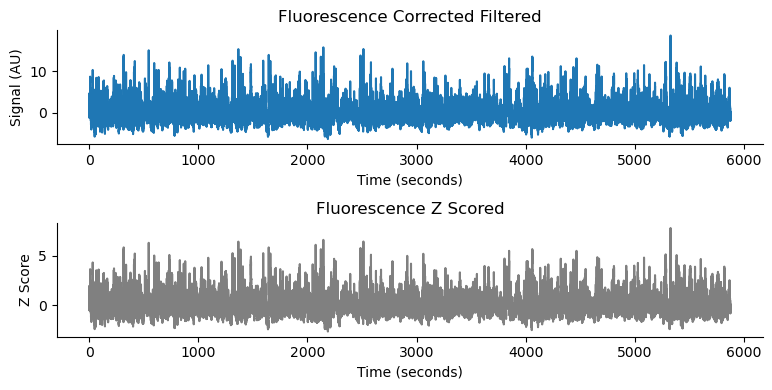

In [10]:
# Calculate the mean and standard deviation of the 'Fluorescence_Corrected_Filtered' column
mean_filtered = df_events_resampled['Fluorescence_Corrected_Filtered'].mean()
std_dev_filtered = df_events_resampled['Fluorescence_Corrected_Filtered'].std()

# Calculate z-scores for the 'Fluorescence_Corrected_Filtered' column
df_events_resampled['Fluorescence_Corrected_Z'] = (df_events_resampled['Fluorescence_Corrected_Filtered'] - mean_filtered) / std_dev_filtered

# Plotting z-scored data
fig, axs = plt.subplots(2, 1, figsize=(8, 4))  # 'figsize' is optional, adjust as needed

# First subplot for 'Fluorescence Corrected'
axs[0].plot(df_events_resampled['TimeStamp'], df_events_resampled['Fluorescence_Corrected_Filtered'])
axs[0].set_title('Fluorescence Corrected Filtered')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal (AU)')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Second subplot for 'Fluorescence Z Scored'
axs[1].plot(df_events_resampled['TimeStamp'], df_events_resampled['Fluorescence_Corrected_Z'], 'gray')
axs[1].set_title('Fluorescence Z Scored')  # Set title for the second subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the second subplot
axs[1].set_ylabel('Z Score')  # Set y-axis label for the second subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Save your processed file:

We're done! Use the save directory widget to specify where you want to save your processed file.

In [11]:
# Text widget to specify the save directory
dir_selector = widgets.Text(
    value=os.getcwd(),
    description='Save Directory:',
    disabled=False
)
display(dir_selector)

# Button to save the processed file
save_button = widgets.Button(description="Save Processed File")
display(save_button)

def save_processed_file(b):
    global directory, filename, df_events_resampled
    save_directory = dir_selector.value
    if os.path.isdir(save_directory) and filename and df_events_resampled is not None:
        new_filename = os.path.join(save_directory, os.path.basename(filename).rsplit('.', 1)[0] + '_processed.csv')
        df_events_resampled.to_csv(new_filename, index=False)
        print(f"Processed file saved as '{new_filename}'.")
    else:
        print("Error: The provided directory does not exist or no file has been processed.")

# Attach the save button click event to the handler function
save_button.on_click(save_processed_file)

Text(value='C:\\Users\\wangjg', description='Save Directory:')

Button(description='Save Processed File', style=ButtonStyle())